# Field Capacity and Hydraulic Conductivity

Field capacity can be defined as the water content $\theta_{fc}$ where
gravitational drainage becomes negligible.

Two common definitions:
1. Fixed matric potential: e.g. $\psi = -330 \ \text{cm}$ (pF = 2.5).
2. Based on conductivity: $K(\theta_{fc}) \approx 0.1 \ \text{mm/d}$.

# Van Genuchten–Mualem Model

Note that the Van Genughten Mualem model differs from that of WUR as published by Heinen, Bakker and Wösten (2020), which as an extra parameter $\lambda$ to compute hydraulic conductivity. 

Soil water retention:
$$
\theta(\psi) = \theta_r + \frac{\theta_s - \theta_r}{\left[1 + (\alpha |\psi|)^n \right]^m},
$$

with $m = 1 - \tfrac{1}{n}$.

Hydraulic conductivity:
$$
K(\psi) = K_s \, S_e^{1/2} \, \big[ 1 - \left(1 - S_e^{1/m}\right)^m \big]^2,
$$

where $S_e = \frac{\theta(\psi) - \theta_r}{\theta_s - \theta_r}$.

## Python Check

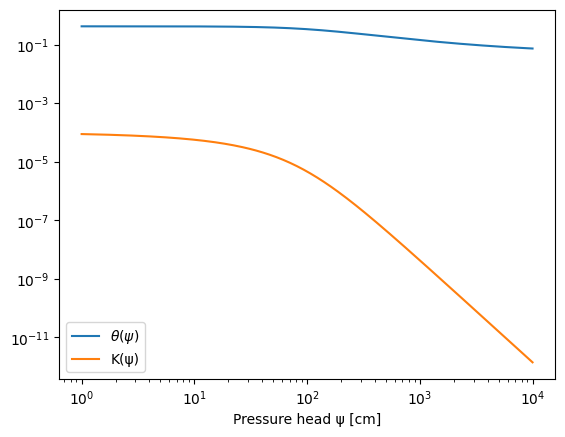

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example Van Genuchten parameters
theta_r, theta_s = 0.05, 0.42
alpha, n, Ks = 0.01, 1.6, 1e-4
m = 1 - 1/n

psi = np.logspace(0, 4, 200)  # suction in cm

theta = theta_r + (theta_s - theta_r) / (1 + (alpha * psi)**n)**m
Se = (theta - theta_r) / (theta_s - theta_r)
K = Ks * Se**0.5 * (1 - (1 - Se**(1/m))**m)**2

plt.loglog(psi, theta, label=r"$\theta(\psi)$")
plt.loglog(psi, K, label="K(ψ)")
plt.xlabel("Pressure head ψ [cm]")
plt.ylabel("")


In [ ]:
plt.grid(True)
plt.legend("theta and K")
plt.show()

# Brooks & Corey

Retention curve:
$$
\theta(\psi) =
\begin{cases}
\theta_s & \psi \le \psi_b \\
\theta_r + (\theta_s - \theta_r) \left(\frac{\psi_b}{\psi}\right)^\lambda & \psi > \psi_b
\end{cases}
$$

👉 With this setup you can:

* Add theory (Markdown cells with equations).
* Run quick checks with Python (Code cells).
* Keep everything in one notebook.

Would you like me to prepare a **ready-to-use `.ipynb` file** with this skeleton so you can open it in VS Code right away?


# Reduction function for non linear water retention

Great question. If you want a reduction function that truly reflects the **non-linear water retention/transport**, there are a few good families. Here are three that are widely used, from “classic and simple” to “most physics-aware.” I’d recommend #3 for your setup, since you already use van Genuchten–Mualem.

---

# 1) Feddes piecewise (the classic)

A piecewise **α(h)** on pressure head $h$ (cm; $h<0$ for unsaturated), with 0–1 scaling and an “optimal” range:

$$
\alpha(h)=
\begin{cases}
0, & h>h_1 \quad\text{(anaerobiosis / too wet)}\\
\frac{h-h_1}{h_{2h}-h_1}, & h_1\ge h>h_{2h}\\
1, & h_{2h}\ge h\ge h_{2l}\\
\frac{h-h_4}{h_{3}-h_4}, & h_{2l}> h \ge h_3\\
0, & h< h_4 \quad\text{(wilting)}
\end{cases}
$$

Typical (order-of-magnitude) values used in many models:

* $h_1\sim -10$ to $-1$ cm (too wet)
* $h_{2h}\sim -25$ cm, $h_{2l}\sim -200$ cm (optimal plateau)
* $h_3$ depends on climate/species, often $-400$ to $-8000$ cm
* $h_4$ near wilting, $\sim -16000$ cm (pF≈4.2)

Pros: simple, interpretable.
Cons: linear segments; not tied to your soil’s nonlinearity except via the breakpoints.

---

# 2) Smooth logistic on pF (fast, tunable)

Let pF $=\log_{10}(|h|)$. Pick pF at field capacity $pF_{fc}\approx2.5$ (|h|≈316 cm) and wilting $pF_w\approx4.2$ (|h|≈15849 cm). Use a smoothed step:

$$
\alpha(\text{pF})=\frac{1}{1+\exp\!\Big(\frac{\text{pF}-\text{pF}_{50}}{s}\Big)}
$$

Clamp to $[0,1]$, and enforce $\alpha=1$ for $\text{pF}\le pF_{fc}$, $\alpha=0$ for $\text{pF}\ge pF_w$.
Choose $\text{pF}_{50}$ around 3.5–3.8 and slope $s$≈0.15–0.30 to control steepness.

Pros: smooth, two parameters, easy to calibrate.
Cons: not directly linked to hydraulic properties—just shaped by pF.

---

# 3) vG–Mualem–based stress via **relative conductivity** (recommended)

As suction increases, uptake is throttled largely because **unsaturated K collapses**. You can harness your existing vG–Mualem functions:

* van Genuchten:

  $$
  S_e(h)=\big(1+(\alpha_v |h|)^n\big)^{-m},\quad m=1-\tfrac{1}{n}
  $$
* Mualem relative conductivity:

  $$
  K_r(h) = S_e(h)^{\ell}\,\Big[1-\big(1-S_e(h)^{1/m}\big)^{m}\Big]^2
  $$

  with pore-connectivity $\ell \approx 0.5$ (often).

Define your transpiration reduction as a **normalized** (and optionally exponentiated) function of $K_r$ between field capacity and wilting:

$$
\alpha(h)=
\begin{cases}
1, & |h|\le |h_{fc}|\\[4pt]
\left(\dfrac{K_r(h)-K_r(h_w)}{K_r(h_{fc})-K_r(h_w)}\right)^{\beta}, & |h_{fc}|<|h|<|h_w|\\[10pt]
0, & |h|\ge |h_w|
\end{cases}
$$

* Take $h_{fc}$ at your chosen FC (e.g. pF 2.5 → $|h_{fc}|\approx316$ cm).
* Take $h_w$ at wilting (pF 4.2 → $|h_w|\approx15849$ cm).
* $\beta\in[0.7,1.3]$ tunes curvature (β>1 steeper drop, β<1 gentler).

Optionally include an **upper wetness penalty** (oxygen stress) by multiplying with a Feddes-style factor $\alpha_\text{wet}(h)$ that drops from 1 to 0 when $h\to 0$ (e.g., linear from $-25$ cm to $-1$ cm). Final:

$$
\alpha_\text{total}(h)=\alpha_\text{wet}(h)\cdot \alpha(h)
$$

**Why this is nice for you:** it automatically mirrors the soil-specific nonlinearity (both $\theta(h)$ and $K(h)$) that you already model with vG–Mualem. You avoid arbitrary linear ramps and “if θ>FC” logic. It also behaves continuously as the root-zone $h$ evolves.

---

## Quick implementation sketch (pseudocode)

```python
def alpha_transp(h, h_fc, h_w, vg_params, l=0.5, beta=1.0):
    # Ensure h < 0 (unsat); take absolute for pF mapping if needed
    Se = (1.0 + (vg.alpha * abs(h))**vg.n)**(-vg.m)
    Kr = Se**l * (1.0 - (1.0 - Se**(1.0/vg.m))**vg.m)**2

    # Precompute constants at fc and wilting once
    Se_fc = (1 + (vg.alpha*abs(h_fc))**vg.n)**(-vg.m)
    Kr_fc = Se_fc**l * (1 - (1 - Se_fc**(1/vg.m))**vg.m)**2

    Se_w  = (1 + (vg.alpha*abs(h_w))**vg.n)**(-vg.m)
    Kr_w  = Se_w**l  * (1 - (1 - Se_w**(1/vg.m))**vg.m)**2

    if abs(h) <= abs(h_fc):
        a = 1.0
    elif abs(h) >= abs(h_w):
        a = 0.0
    else:
        a = ((Kr - Kr_w) / (Kr_fc - Kr_w))**beta
        a = max(0.0, min(1.0, a))
    return a
```

Add an oxygen-stress multiplier if you want upper-wet reduction:

```python
def alpha_wet(h, h1=-10.0, h2=-25.0):  # cm
    if h > h1:         return 0.0
    if h >= h2:        return (h - h1) / (h2 - h1)
    return 1.0
```

Final: `alpha_total = alpha_wet(h) * alpha_transp(h, ...)`.

---

## Notes & tips

* Your “uniform root-zone” assumption maps neatly to a single $h$ (or pF) state variable per time step; just evaluate $\alpha(h)$ at that value.
* You can calibrate **β** and (if used) the **wet-end breakpoints** using ET observations (e.g., sapflow or ET partitioning) without touching your vG parameters.
* If you prefer working in **pF** directly, the logistic function (#2) is a quick and smooth alternative; you can even set $pF_{50}$ from the $h$ where $K_r$ drops to 0.5 to link it loosely to soil physics.

If you want, I can plug your **B01 sand** vG parameters into #3 and show how $\alpha(h)$ compares to a Feddes curve and a logistic on pF, so you can pick a default.


You’re right—my Feddes piecewise had a gap. The **dry-side interval** must be $h_3 \ge h \ge h_4$. A consistent Feddes response (with pressure head $h<0$, “wetter” = closer to 0) is:

$$
\alpha(h)=
\begin{cases}
0, & h>h_1 \\[4pt]
\dfrac{h-h_1}{\,h_2-h_1\,}, & h_1\ge h>h_2 \\[8pt]
1, & h_2\ge h\ge h_3 \\[4pt]
\dfrac{h-h_4}{\,h_3-h_4\,}, & h_3> h \ge h_4 \\[8pt]
0, & h<h_4
\end{cases}
\qquad\text{with } h_1>h_2>h_3>h_4\ (<0).
$$

Notes:

* $h_2$ and $h_3$ can each have “high/low” variants (Feddes uses $h_{2h}, h_{2l}$ and $h_{3h}, h_{3l}$) depending on potential transpiration; you pick the appropriate $h_2, h_3$ for the current condition.
* At $h=h_3$ the function leaves the plateau and **declines linearly** to zero at $h_4$.

### Minimal Python

```python
def feddes_alpha(h, h1, h2, h3, h4):
    # h1 > h2 > h3 > h4 (all negative)
    if h > h1:
        return 0.0
    elif h1 >= h > h2:
        return (h - h1) / (h2 - h1)
    elif h2 >= h >= h3:
        return 1.0
    elif h3 > h >= h4:
        return (h - h4) / (h3 - h4)
    else:  # h < h4
        return 0.0
```

Thanks for catching that—this version is gap-free and matches the standard Feddes formulation.
